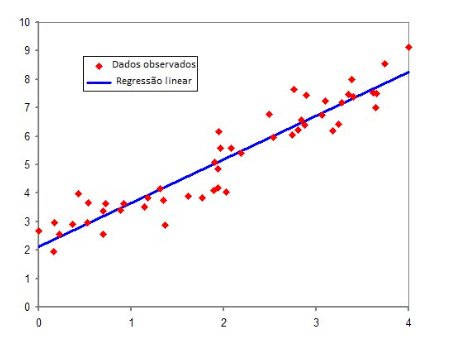

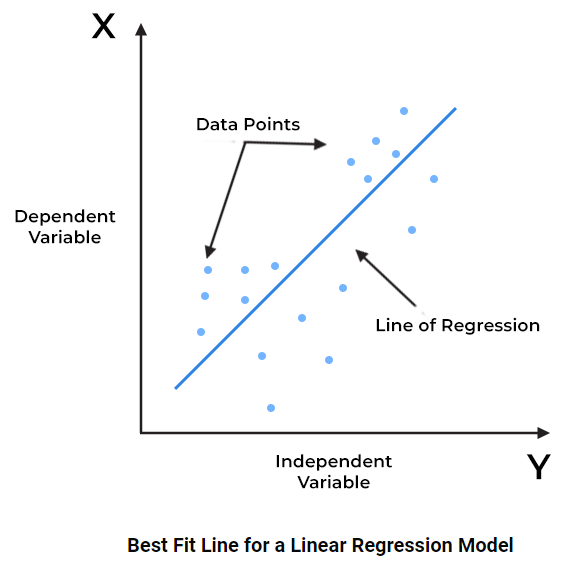

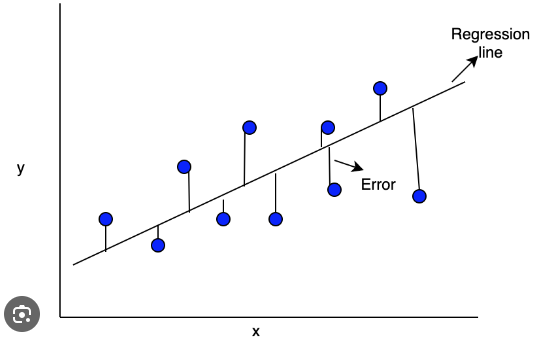

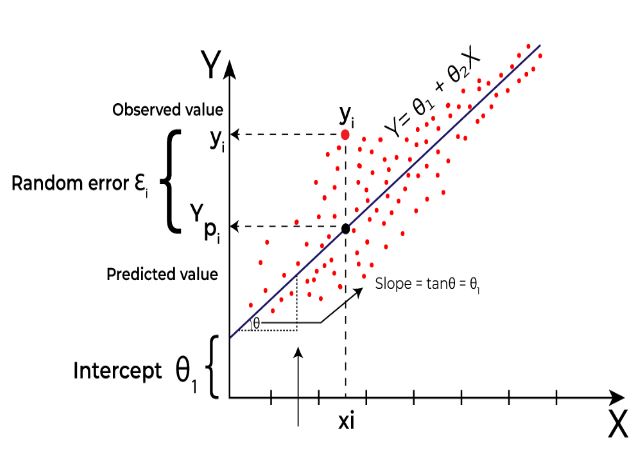

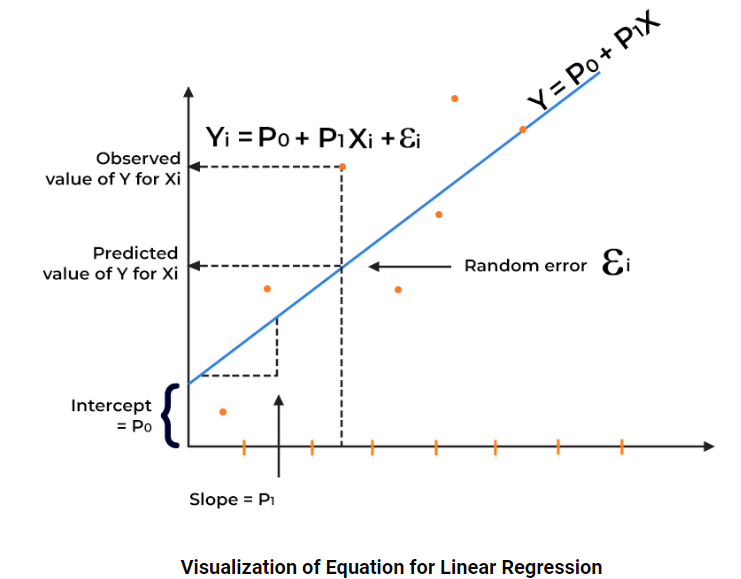

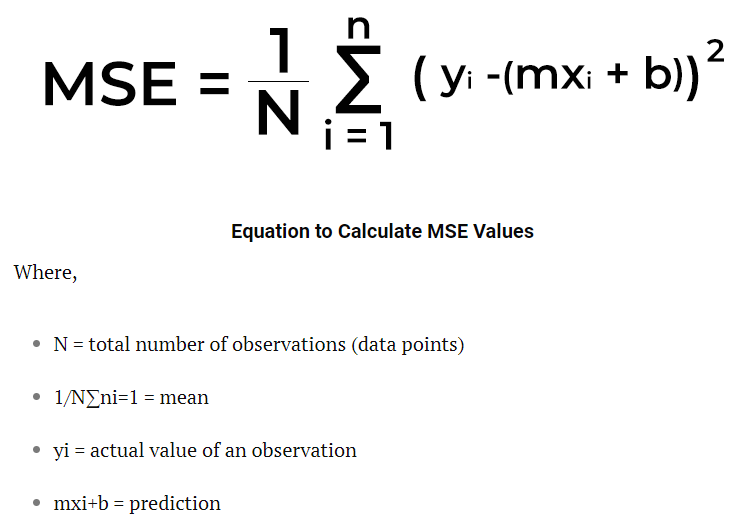

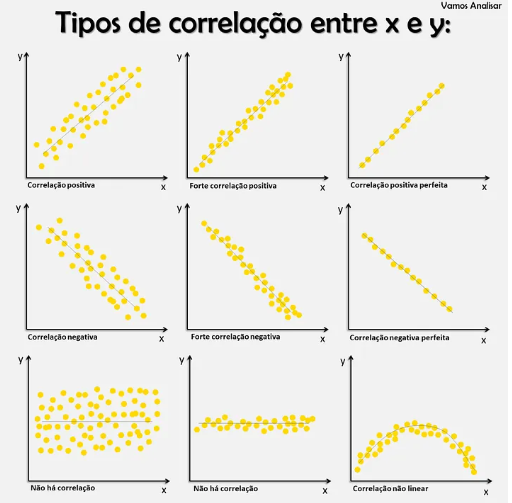

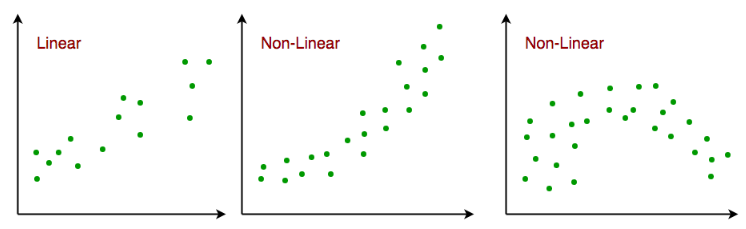

# 3.5. Concise Implementation of Linear Regression

# 3.5.1. Definindo o Modelo

Na Seção 3.4 , contamos apenas com (i) tensores para armazenamento de dados e álgebra linear; e (ii) diferenciação automática para cálculo de gradientes. 

Na prática, como iteradores de dados, funções de perda, otimizadores e camadas de redes neurais são tão comuns, as bibliotecas modernas também implementam esses componentes para nós. 

Nesta seção, mostraremos como implementar o modelo de regressão linear da Seção 3.4 de forma concisa usando APIs de alto nível de estruturas de aprendizado profundo.

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Para operações padrão, podemos usar camadas predefinidas de um framework, o que nos permite focar nas camadas usadas para construir o modelo em vez de nos preocupar com sua implementação.

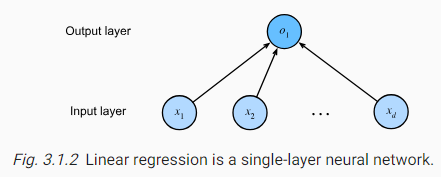

 A camada é chamada totalmente conectada , pois cada uma de suas entradas está conectada a cada uma de suas saídas por meio de uma multiplicação matriz-vetor.

No PyTorch, a camada totalmente conectada é definida nas classes _Linear_ e _LazyLinear_ (disponível desde a versão 1.8.0).

_LazyLinear_ permite que os usuários especifiquem apenas a dimensão da saída.

_Linear_ pergunta adicionalmente quantas entradas vão para esta camada.

 Assim, para simplificar, usaremos essas camadas “preguiçosas” sempre que pudermos.

In [ ]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):  # lr é a taxa de aprendizado. Único parâmetro a ser atribuído ao chamar a classe LinearRegression.
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)             # Especifica a dimensão da saída
        self.net.weight.data.normal_(0, 0.01)   # Distribuição normal: média e desvio padrão?
        self.net.bias.data.fill_(0)

In [ ]:
# apenas invocamos o método integrado __call__ das camadas predefinidas para calcular as saídas.

@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

# 3.5.2. Definindo a Função de Perda

Por padrão, MSELoss retorna a perda média dos exemplos (e calcula o erro quadrático médio), sem o 1/2 de 3.1.5.

É mais rápido (e mais fácil de usar) do que implementar o nosso próprio.

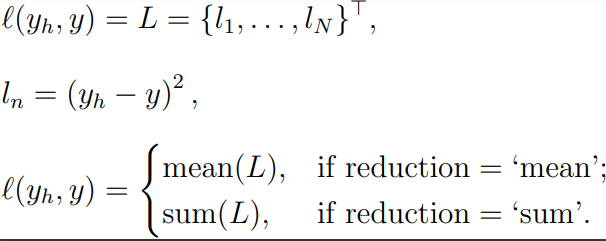

In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

# 3.5.3. Definindo o Algoritmo de Otimização

Minibatch SGD (Descida do Gradiente Estocástico - Minilote) é uma ferramenta padrão para otimização de redes neurais e, portanto, PyTorch o suporta junto com uma série de variações deste algoritmo no módulo _optim_. 

Quando instanciamos uma instância SGD, especificamos os parâmetros a serem otimizados, obtidos em nosso modelo via _self.parameters()_ e taxa de aprendizado _self.lr_ exigida por nosso algoritmo de otimização.

In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

# 3.5.4. Treinamento

Você deve ter notado que expressar nosso modelo por meio de APIs de alto nível de uma estrutura de aprendizado profundo requer menos linhas de código. Não tivemos que alocar parâmetros individualmente, definir nossa função de perda ou implementar SGD de minilote. Assim que começarmos a trabalhar com modelos muito mais complexos, as vantagens da API de alto nível crescerão consideravelmente.

Agora que temos todas as peças básicas instaladas, o ciclo de treinamento em si é o mesmo que implementamos do zero. Portanto, apenas chamamos o fit método (introduzido na Seção 3.2.4 ), que depende da implementação do fit_epoc hmétodo na Seção 3.4 , para treinar nosso modelo.


In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Abaixo, comparamos os parâmetros do modelo aprendidos pelo treinamento e os parâmetros reais que geraram nosso conjunto de dados. 

Para acessar os parâmetros, acessamos os pesos(w) e bias(b) da camada que precisamos. 

Tal como na nossa implementação do zero, note que os parâmetros estimados estão próximos dos seus homólogos reais.

In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

Esta seção contém a primeira implementação de uma rede profunda, aproveitando as conveniências oferecidas pelas estruturas modernas de aprendizagem profunda, como PyTorch.

Usamos padrões de framework para carregar dados, definir uma camada, uma função de perda, um otimizador e um loop de treinamento. 

__Sempre que a estrutura fornecer todos os recursos necessários, geralmente é uma boa ideia usá-los, uma vez que as implementações da biblioteca desses componentes tendem a ser fortemente otimizadas para desempenho e devidamente testadas quanto à confiabilidade.__ 

__Ao mesmo tempo, tente não esquecer que esses módulos podem ser implementados diretamente (manualmente). Isto é especialmente importante para aspirantes a pesquisadores que desejam viver na vanguarda do desenvolvimento de modelos, onde você estará inventando novos componentes que podem não existir em nenhuma biblioteca atual.__

No PyTorch, o módulo _data_  fornece ferramentas para processamento de dados. 

O __módulo__ __nn__ define um grande número de camadas de rede neural e funções de perda comuns (__keras no TensorFlow__). 

Podemos inicializar os parâmetros substituindo seus valores por métodos que terminam em _. 

Observe que precisamos especificar as dimensões de entrada da rede. Embora isso seja trivial por enquanto, pode ter efeitos colaterais significativos quando queremos projetar redes complexas com muitas camadas. Considerações cuidadosas sobre como parametrizar essas redes são necessárias para permitir a portabilidade.

# Código Completo - Conciso

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):  # lr é a taxa de aprendizagem. Único parâmetro a ser atribuído ao chamar a classe LinearRegression.
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)             # Especifica a dimensão da saída (biblioteca nn)
        self.net.weight.data.normal_(0, 0.01)   # Distribuição normal: média=0 e desvio padrão=0.01
        self.net.bias.data.fill_(0)             # bias=b=0.

    def forward(self, X):
        return self.net(X)
     
    def loss(self, y_hat, y):
        fn = nn.MSELoss()                       # Na biblioteca nn
        return fn(y_hat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)


model = LinearRegression(lr=0.03)                                        # lr é a taxa de aprendizagem.
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)     # Classe definida anteriormente, presente na biblioteca d2l.

trainer = d2l.Trainer(max_epochs=3)                                      # Classe definida anteriormente, presente na biblioteca d2l.
trainer.fit(model, data)

w, b = model.get_w_b()
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

# Gráfico - Dispersão

#--------------------------------------------------------------------------------------------------------------------------- \
data: SyntheticRegressionData; Com ruído (noise); y ruidoso; y 'real'; y; dados sinteticos ('simula dados reais') \
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)  # os dados sintéticos 'reais' estão em data (conhecido) \
#---------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------- \
Objetivo: encontrar w e b. \
model: LinearRegressionScratch; Sem ruído (noise); y linear; y predito; y_hat; regresão linear (y predito, chamado de hipótese ou modelo ) \
model = LinearRegressionScratch(2, lr=0.03)  # a regressão linear é feita em model (estimado) \
#---------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------- \
Função custo (Erro_MSE) \
    def loss(self, y_hat, y): \
        l = (y_hat - y) ** 2 / 2  #  Valor conhecido: y;  Valor previsto: y_hat. \
        return l.mean() \
#---------------------------------------------------------------------------------------------------------------------------


In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


class LinearRegression(d2l.Module):  # @save
    """The linear regression model implemented with high-level APIs."""

    def __init__(self, lr):  # lr é a taxa de aprendizagem. Único parâmetro a ser atribuído ao chamar a classe LinearRegression.
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)  # Especifica a dimensão da saída (biblioteca nn)
        self.net.weight.data.normal_(0, 0.01)  # Distribuição normal: média=0 e desvio padrão=0.01
        self.net.bias.data.fill_(0)  # bias=b=0.

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        fn = nn.MSELoss()  # Na biblioteca nn. Tipo de perda utilizada: MSE - Mean Squared Error (squared L2 norm)
        # fn = nn.MSELoss(reduction: str = 'mean')
        # fn = nn.MSELoss(reduction = 'sum')
        # fn = nn.HuberLoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)



model = LinearRegression(lr=0.03)  # lr é a taxa de aprendizagem.
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)  # Classe definida anteriormente, presente na biblioteca d2l.
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2, num_train=5000, num_val=5000)  # Classe definida anteriormente, presente na biblioteca d2l.
n = data.num_train + data.num_val
# data.num_train
# data.num_val

trainer = d2l.Trainer(max_epochs=5)  # Classe definida anteriormente, presente na biblioteca d2l.
trainer.fit(model, data)

w, b = model.get_w_b()

print(f'Amount of data: {n}')
print(f'lr: {model.lr}')
print(f'Epochs: {trainer.max_epochs}')
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

# --------------------------------------------------------------------------------------------------------------
# Para coluna 0 de X. Não tenho certeza se minha interpretação está correta., por X ser 1000x2.
# Cada dimensão deve ser plotada em separado?

# Objetivo: Prever w e b, dado data.X.
# Dados reais:
eixo_x=data.X[:,0]
eixo_x = eixo_x.reshape(1,2000)
eixo_y=data.y.T
# eixo_y = data.w[0]*eixo_x + data.b + data.noise

# Dados preditos ou modelo
eixo_x_hat=torch.arange(-5,5,0.005).reshape(1,2000)
# eixo_x2=torch.arange(-8,8,0.008).reshape(1,2000)
# eixo_y_hat = eixo_x_hat*w[0] + b
eixo_y_hat = w[0,0]*eixo_x_hat + b

d2l.plt.figure(figsize=(3.5, 2.5))
d2l.plot(eixo_x_hat, eixo_y_hat, fmts='g-.')
d2l.plt.scatter(eixo_x, eixo_y, 1)
d2l.plt.show()


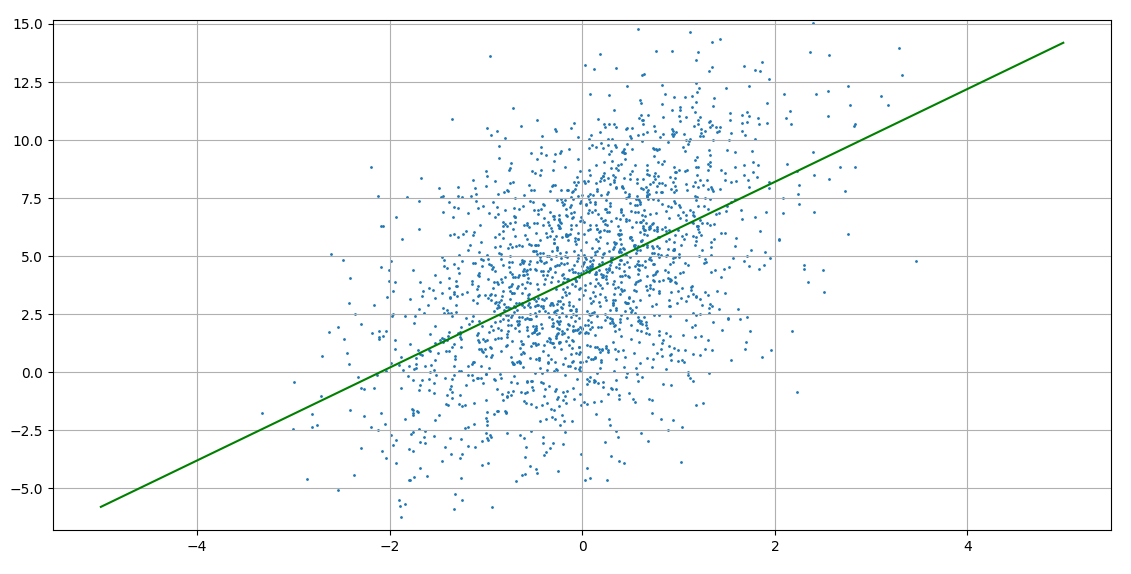

# Gráfico - Dispersão - X com 1 dimensão

epochs=3

In [ ]:
# %matplotlib inline
import torch
import random
from d2l import torch as d2l
from torch import nn
import numpy as np


# -------------------------------------------------------------------------------------------------------------------
class Module(nn.Module, d2l.HyperParameters):  # @save
    """The base class of models."""

    def __init__(self, plot_train_per_epoch=2,
                 plot_valid_per_epoch=1):  # Método Construtor: Recebe os atributos iniciais da classe ao criar um objeto
        super().__init__()  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()  # Classe utilitária definida anteriormente
        self.board = ProgressBoard()  # Classe utilitária definida anteriormente

    def loss(self, y_hat, y):  # Função perda. Ainda não implementada.
        raise NotImplementedError

    def forward(self, X):  # Backpropagation?
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):  # plot
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):  # treinamento
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):  # validação
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):  # otimizadores
        raise NotImplementedError


# -------------------------------------------------------------------------------------------------------------------

class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self,
                X):  # O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(X, self.w) + self.b  # Produto entre X que é a matriz de dados e w que é o vetor de pesos

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2  # Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)


# -------------------------------------------------------------------------------------------------------------------

class SGD(d2l.HyperParameters):  # @save
    """Minibatch stochastic gradient descent."""

    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):  # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad  # param = param - self.lr * param.grad

    def zero_grad(
            self):  # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


# -------------------------------------------------------------------------------------------------------------------
class Trainer(d2l.HyperParameters):  # @save
    """The base class for training models with data."""

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):  # Método chave. model é uma instância de Module, e data, uma instância de DataModule
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):  # @d2l.add_to_class(d2l.Trainer)  #@save
        return batch

    def fit_epoch(self):  # @d2l.add_to_class(d2l.Trainer)  #@save
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1


# -------------------------------------------------------------------------------------------------------------------
class DataModule(d2l.HyperParameters):  # @save
    """The base class of data."""

    def __init__(self, root='../data', num_workers=4):  # usado para preparar os dados.
        self.save_hyperparameters()

    def get_dataloader(self, train):  # Carregador de dados. Produz um lote de dados cada vez que é usado.
        raise NotImplementedError

    def train_dataloader(self):  # retorna o carregador de dados para o conjunto de dados de treinamento.
        return self.get_dataloader(train=True)

    def val_dataloader(self):  # opcional: retorna o carregador do conjunto de dados de validação.
        return self.get_dataloader(train=False)


# -------------------------------------------------------------------------------------------------------------------
class SyntheticRegressionData(d2l.DataModule):  # @save
    """Synthetic data for linear regression."""

    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):  # batch=lotes de tamanho 32
        super().__init__()  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()
        n = num_train + num_val  # n = n_treinamento + n_validação = 1000 + 1000 = 2000
        self.X = torch.randn(n, len(w))  # matriz X (2000x2) com elementos aleatórios
        noise = torch.randn(n, 1) * noise  # vetor noise (2000x1) com elementos aleatórios
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

    # Captura minilotes
    # def get_dataloader(self, train):
    #     if train:
    #         indices = list(range(0, self.num_train))
    #         # The examples are read in random order
    #         random.shuffle(indices)
    #     else:
    #         indices = list(range(self.num_train, self.num_train+self.num_val))
    #     for i in range(0, len(indices), self.batch_size):
    #         batch_indices = torch.tensor(indices[i: i+self.batch_size])
    #         yield self.X[batch_indices], self.y[batch_indices]                  # bathc = lote
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)


# -------------------------------------------------------------------------------------------------------------------
model = LinearRegressionScratch(1, lr=0.03)
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data = SyntheticRegressionData(w=torch.tensor([2.0]), b=4.2)
# trainer = d2l.Trainer(max_epochs=3)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')

# -------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)


# --------------------------------------------------------------------------------------------------------------
# Para coluna 0 de X. Não tenho certeza se minha interpretação está correta.

# Objetivo: Prever w e b, dado data.X.
# Dados reais:
eixo_x=data.X.reshape(1,2000)
eixo_y=data.y.T
# eixo_y = data.w[0]*eixo_x + data.b + data.noise

# Dados preditos ou modelo
eixo_x_hat=eixo_x
# eixo_x_hat=torch.arange(-5,5,0.005).reshape(1,2000)
# eixo_x2=torch.arange(-8,8,0.008).reshape(1,2000)
# eixo_y_hat = eixo_x_hat*w[0] + b
eixo_y_hat = model.w*eixo_x_hat + model.b
eixo_y_hat = eixo_y_hat.data    # para eliminar grad_fn=<AddBackward0>. Pega apenas os dados.

d2l.plt.figure(figsize=(3.5, 2.5))
d2l.plot(eixo_x_hat, eixo_y_hat, fmts='g-.')
d2l.plt.scatter(eixo_x, eixo_y, 1)
d2l.plt.show()


eixo_y_hat.grad_fn

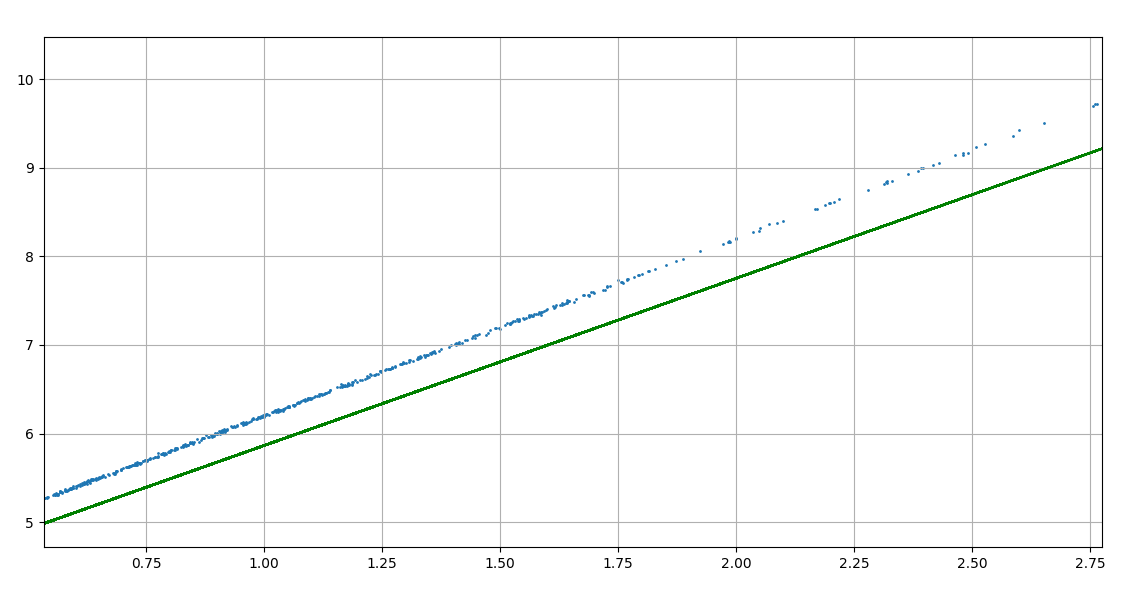

epochs = 10

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
model = LinearRegressionScratch(1, lr=0.03)
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data = SyntheticRegressionData(w=torch.tensor([2.0]), b=4.2)
# trainer = d2l.Trainer(max_epochs=3)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')

# -------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)



# --------------------------------------------------------------------------------------------------------------
# Para coluna 0 de X. Não tenho certeza se minha interpretação está correta.

# Objetivo: Prever w e b, dado data.X.
# Dados reais:
eixo_x=data.X.reshape(1,2000)
eixo_y=data.y.T
# eixo_y = data.w[0]*eixo_x + data.b + data.noise

# Dados preditos ou modelo
eixo_x_hat=eixo_x
# eixo_x_hat=torch.arange(-5,5,0.005).reshape(1,2000)
# eixo_x2=torch.arange(-8,8,0.008).reshape(1,2000)
# eixo_y_hat = eixo_x_hat*w[0] + b
eixo_y_hat = model.w*eixo_x_hat + model.b
eixo_y_hat = eixo_y_hat.data    # para eliminar grad_fn=<AddBackward0>. Pega apenas os dados.

d2l.plt.figure(figsize=(3.5, 2.5))
d2l.plot(eixo_x_hat, eixo_y_hat, fmts='g-.')
d2l.plt.scatter(eixo_x, eixo_y, 1)
d2l.plt.show()


eixo_y_hat.grad_fn

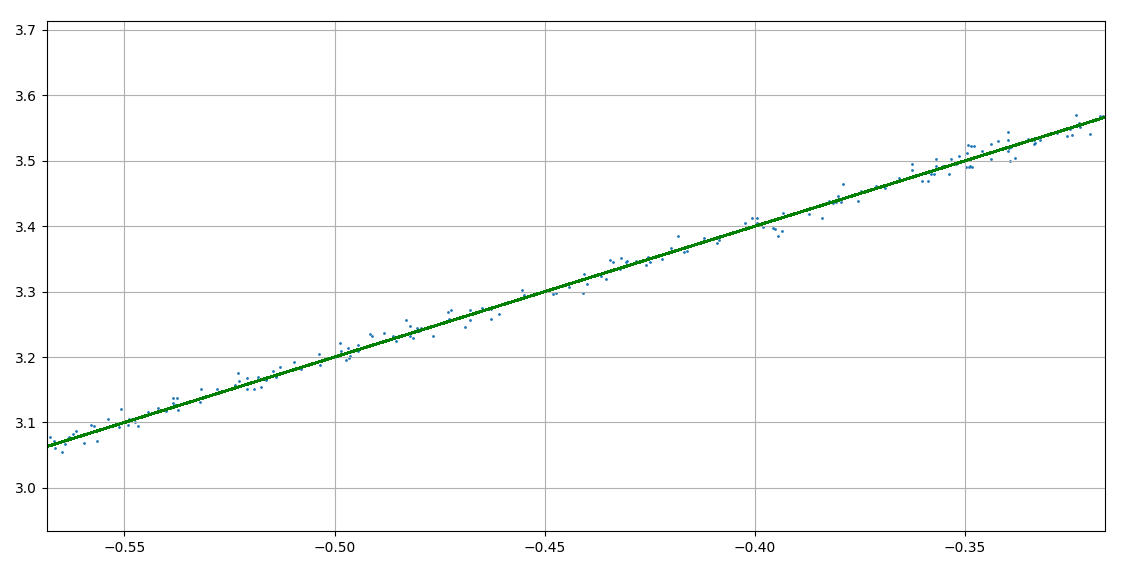

# Gráfico - Dispersão - Vetor X externo, com 1 dimensão.

Vetor X vem da planilha dados_menor.csv, que será utilizada no doutorado.

Código completo do: \
cap3_3.4-LR-Implementation_Scratch_Do zero

Trainer(max_epochs=10)

In [ ]:
import torch
from d2l import torch as d2l
from torch import nn
import os
import pandas as pd

# ------------------------------------------------------------------------------------------------------
data_file = os.path.join('..', 'G:\Meu Drive\\0-DOUTORADO\\0-Python\\PycharmProjects\\DNN_NILM\\dados\\dados_menor.csv')
data1 = pd.read_csv(data_file)   # Lê os dados em data_file
print(data1)                     # imprime os dados

# Medidores
meter_id_1	= data1.iloc[0:846,2:394]
meter_id_torch_1 = torch.tensor(meter_id_1.to_numpy())

meter_id_2	= data1.iloc[847:1693,2:394]
meter_id_torch_2 = torch.tensor(meter_id_2.to_numpy())

# -------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------
# Entrada X:
i_an_id2 = meter_id_torch_2[490:846,2].reshape(356,1)  # i_an do meter_id_torch_2
i_an_id2 = torch.tensor(i_an_id2, dtype=torch.float32) # convert float64 from float32
# X_tensor = torch.tensor(X_before, dtype=torch.float32)

# -------------------------------------------------------------------------------------------------------------------
class Module(nn.Module, d2l.HyperParameters):  # @save
    """The base class of models."""

    def __init__(self, plot_train_per_epoch=2,
                 plot_valid_per_epoch=1):  # Método Construtor: Recebe os atributos iniciais da classe ao criar um objeto
        super().__init__()  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()  # Classe utilitária definida anteriormente
        self.board = ProgressBoard()  # Classe utilitária definida anteriormente

    def loss(self, y_hat, y):  # Função perda. Ainda não implementada.
        raise NotImplementedError

    def forward(self, X):  # Backpropagation?
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):  # plot
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):  # treinamento
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):  # validação
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):  # otimizadores
        raise NotImplementedError

# -------------------------------------------------------------------------------------------------------------------
class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self,
                X):  # O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(X, self.w) + self.b  # Produto entre X que é a matriz de dados e w que é o vetor de pesos

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2  # Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)

# -------------------------------------------------------------------------------------------------------------------
class SGD(d2l.HyperParameters):  # @save
    """Minibatch stochastic gradient descent."""

    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):  # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad  # param = param - self.lr * param.grad

    def zero_grad(
            self):  # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# -------------------------------------------------------------------------------------------------------------------
class Trainer(d2l.HyperParameters):  # @save
    """The base class for training models with data."""

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):  # Método chave. model é uma instância de Module, e data, uma instância de DataModule
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):  # @d2l.add_to_class(d2l.Trainer)  #@save
        return batch

    def fit_epoch(self):  # @d2l.add_to_class(d2l.Trainer)  #@save
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

# -------------------------------------------------------------------------------------------------------------------
class DataModule(d2l.HyperParameters):  # @save
    """The base class of data."""

    def __init__(self, root='../data', num_workers=4):  # usado para preparar os dados.
        self.save_hyperparameters()

    def get_dataloader(self, train):  # Carregador de dados. Produz um lote de dados cada vez que é usado.
        raise NotImplementedError

    def train_dataloader(self):  # retorna o carregador de dados para o conjunto de dados de treinamento.
        return self.get_dataloader(train=True)

    def val_dataloader(self):  # opcional: retorna o carregador do conjunto de dados de validação.
        return self.get_dataloader(train=False)

# -------------------------------------------------------------------------------------------------------------------
class SyntheticRegressionData(d2l.DataModule):  # @save
    """Synthetic data for linear regression."""

    def __init__(self, w, b, noise=0.01, num_train=178, num_val=178,
                 batch_size=32):  # batch=lotes de tamanho 32
        super().__init__()  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()
        n = num_train + num_val  # n = n_treinamento + n_validação = 178+178=356
        # self.X = torch.randn(n, len(w))  # matriz X (2000x2) com elementos aleatórios
        self.X = i_an_id2  # (356x1)
        noise = torch.randn(n, 1) * noise  # vetor noise (2000x1) com elementos aleatórios
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

# -------------------------------------------------------------------------------------------------------------------
model = LinearRegressionScratch(1, lr=0.03)
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data = SyntheticRegressionData(w=torch.tensor([2.0]), b=4.2)
# trainer = d2l.Trainer(max_epochs=3)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')

# -------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)


# --------------------------------------------------------------------------------------------------------------
# Para coluna 0 de X. Não tenho certeza se minha interpretação está correta.

# Objetivo: Prever w e b, dado data.X.
# Dados reais:
eixo_x=data.X.reshape(1,356)
eixo_y=data.y.T
# eixo_y = data.w[0]*eixo_x + data.b + data.noise

# Dados preditos ou modelo
eixo_x_hat=eixo_x
# eixo_x_hat=torch.arange(-5,5,0.005).reshape(1,2000)
# eixo_x2=torch.arange(-8,8,0.008).reshape(1,2000)
# eixo_y_hat = eixo_x_hat*w[0] + b
eixo_y_hat = model.w*eixo_x_hat + model.b
eixo_y_hat = eixo_y_hat.data    # para eliminar grad_fn=<AddBackward0>. Pega apenas os dados.

d2l.plt.figure(figsize=(3.5, 2.5))
d2l.plot(eixo_x_hat, eixo_y_hat, fmts='g-.')
d2l.plt.scatter(eixo_x, eixo_y, 1)
d2l.plt.axis([7.1, 7.5, 18.4, 19.2])
d2l.plt.show()



Trainer(max_epochs=500)

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
model = LinearRegressionScratch(1, lr=0.03)
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data = SyntheticRegressionData(w=torch.tensor([2.0]), b=4.2)
# trainer = d2l.Trainer(max_epochs=3)
trainer = Trainer(max_epochs=500)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')

# -------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)


# --------------------------------------------------------------------------------------------------------------
# Para coluna 0 de X. Não tenho certeza se minha interpretação está correta.

# Objetivo: Prever w e b, dado data.X.
# Dados reais:
eixo_x=data.X.reshape(1,356)
eixo_y=data.y.T
# eixo_y = data.w[0]*eixo_x + data.b + data.noise

# Dados preditos ou modelo
eixo_x_hat=eixo_x
# eixo_x_hat=torch.arange(-5,5,0.005).reshape(1,2000)
# eixo_x2=torch.arange(-8,8,0.008).reshape(1,2000)
# eixo_y_hat = eixo_x_hat*w[0] + b
eixo_y_hat = model.w*eixo_x_hat + model.b
eixo_y_hat = eixo_y_hat.data    # para eliminar grad_fn=<AddBackward0>. Pega apenas os dados.

d2l.plt.figure(figsize=(3.5, 2.5))
d2l.plot(eixo_x_hat, eixo_y_hat, fmts='g-.')
d2l.plt.scatter(eixo_x, eixo_y, 1)
d2l.plt.axis([7.1, 7.5, 18.4, 19.2])
d2l.plt.show()



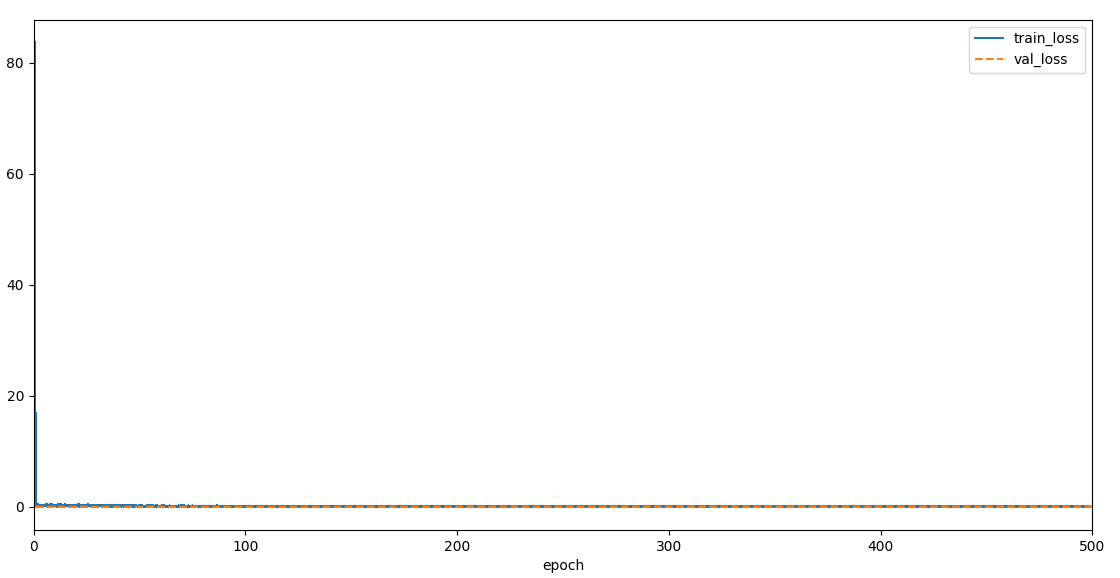

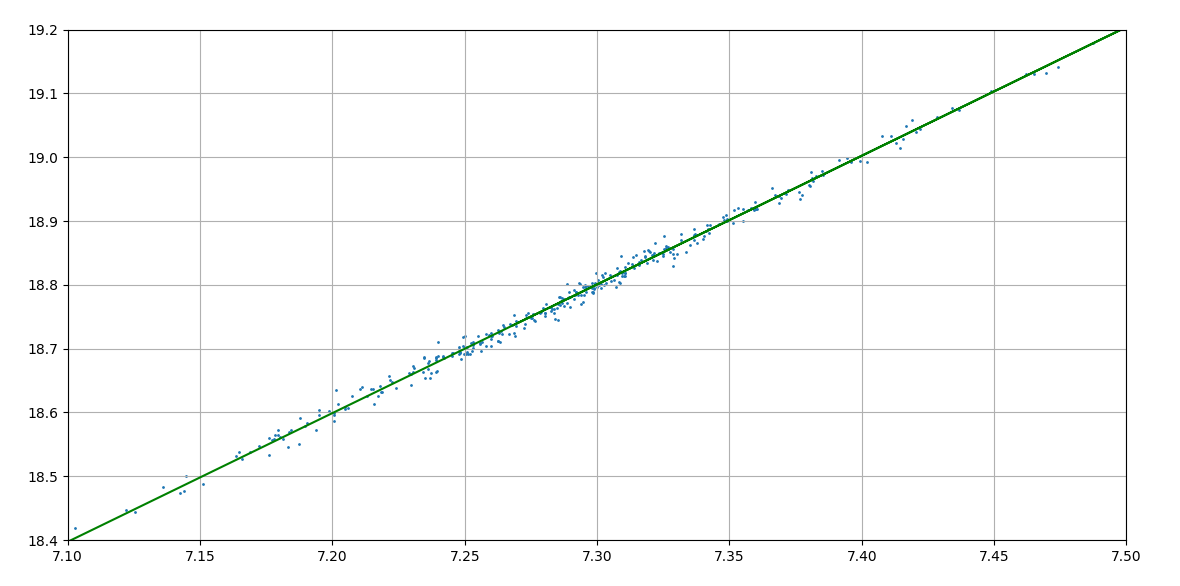

# Exercícios:

# Ex. 1
How would you need to change the learning rate if you replace the aggregate loss over the minibatch with an average over the loss on the minibatch?



fn = nn.MSELoss(reduction = 'mean')   # default \
Amount of data: 2000 \
lr: 0.03 \ 
Epochs: 3 \
error in estimating w: tensor([ 0.0111, -0.0090]) \
error in estimating b: tensor([0.0119])


fn = nn.MSELoss(reduction = 'sum') \
Amount of data: 2000 \
lr: 0.03 \
Epochs: 3 \
error in estimating w: tensor([ 0.0124, -0.0122]) \
error in estimating b: tensor([-0.0153]) \
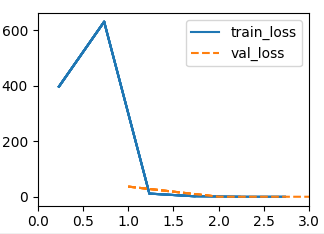


fn = nn.MSELoss(reduction = 'sum') \
Amount of data: 2000 \
lr: 0.05 \
Epochs: 3 \
error in estimating w: tensor([-4.8256e+28, -1.1236e+29]) \
error in estimating b: tensor([1.0544e+29]) \
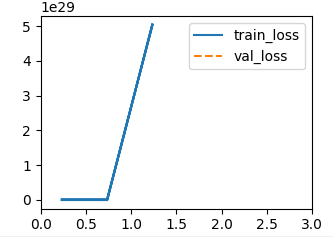


fn = nn.MSELoss(reduction = 'sum') \
Amount of data: 2000 \
lr: 0.01 \
Epochs: 3 \
error in estimating w: tensor([-0.0005,  0.0006]) \
error in estimating b: tensor([0.0004]) \
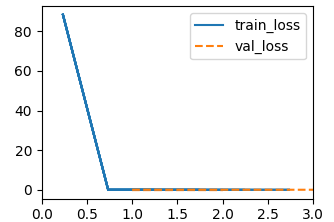

Therefore, it's necessary to reduce the lr for reduction = 'sum'.

# Ex. 2:

Review the framework documentation to see which loss functions are provided. In particular, replace the squared loss with Huber’s robust loss function. That is, use the loss function

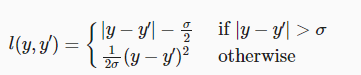

__Answer:__

In class _Loss(Module), classes:


class L1Loss(_Loss):

class NLLLoss(_WeightedLoss):

class NLLLoss2d(NLLLoss):

class PoissonNLLLoss(_Loss):

class GaussianNLLLoss(_Loss):

class KLDivLoss(_Loss):

class MSELoss(_Loss):                        #

class BCELoss(_WeightedLoss):

class BCEWithLogitsLoss(_Loss):

class HingeEmbeddingLoss(_Loss):

class MultiLabelMarginLoss(_Loss):

class SmoothL1Loss(_Loss):

class HuberLoss(_Loss):                       #

class SoftMarginLoss(_Loss):

class CrossEntropyLoss(_WeightedLoss):

class MultiLabelSoftMarginLoss(_WeightedLoss):

class CosineEmbeddingLoss(_Loss):

class MarginRankingLoss(_Loss):

class MultiMarginLoss(_WeightedLoss):

class TripletMarginLoss(_Loss):

class TripletMarginWithDistanceLoss(_Loss):

class CTCLoss(_Loss):



In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    # fn = nn.MSELoss()  # MSE - Mean Squared Error (squared L2 norm)
    fn = nn.HuberLoss()  # <<---------------------------
    return fn(y_hat, y)

model = LinearRegression(lr=0.03)  # lr é a taxa de aprendizagem.
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)  # Classe definida anteriormente, presente na biblioteca d2l.

trainer = d2l.Trainer(max_epochs=3)  # Classe definida anteriormente, presente na biblioteca d2l.
trainer.fit(model, data)

w, b = model.get_w_b()
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

# Ex. 3

How do you access the gradient of the weights of the model?

__Answer:__ model.net.weight.grad 

# Ex. 4:

What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?

__Answer:__ 

lr: 0.009 \
Epochs: 3 \
error in estimating w: tensor([ 0.4282, -0.4909]) \
error in estimating b: tensor([0.6680]) 

__lr: 0.03__ \
__Epochs: 3__ \
error in estimating w: tensor([ 0.0059, -0.0102]) \
error in estimating b: tensor([0.0125]) 

lr: 0.08 \
Epochs: 3 \
error in estimating w: tensor([ 0.0001, -0.0009]) \
error in estimating b: tensor([0.0004]) 

lr: 0.13 \
Epochs: 3 \
error in estimating w: tensor([ 0.0008, -0.0001]) \
error in estimating b: tensor([0.0019]) 

lr: 0.2 \
Epochs: 3 \
error in estimating w: tensor([ 0.0009, -0.0022]) \
error in estimating b: tensor([0.0012]) 

lr: 1 \
Epochs: 3 \
error in estimating w: tensor([ 2526.8345, 15897.2402]) \
error in estimating b: tensor([-7285.6177]) 

-----------------------------------------------------------------------

lr: 0.009 \
Epochs: 3 \
error in estimating w: tensor([ 0.4282, -0.4909]) \
error in estimating b: tensor([0.6680]) 

lr: 0.009 \
Epochs: 5 \
error in estimating w: tensor([ 0.1119, -0.1205]) \
error in estimating b: tensor([0.2299]) 

lr: 0.009 \
Epochs: 10 \
error in estimating w: tensor([ 0.0064, -0.0095]) \
error in estimating b: tensor([0.0145]) 


# Ex. 5: 

How does the solution change as you vary the amount of data generated?

1.Plot the estimation error for w'-w and b'-b as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, …, 10,000 rather than 1000, 2000, …, 10,000.


In [ ]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2, num_train=25, num_val=25)  


Amount of data: 50 \
lr: 0.03 \
Epochs: 10 \
error in estimating w: tensor([ 1.1109, -1.4495]) \
error in estimating b: tensor([2.3601]) \
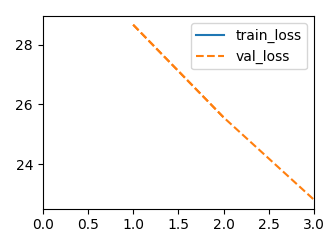

Amount of data: 200 \
lr: 0.03 \
Epochs: 3 \
error in estimating w: tensor([ 0.6428, -1.5883])\
error in estimating b: tensor([2.4319])\
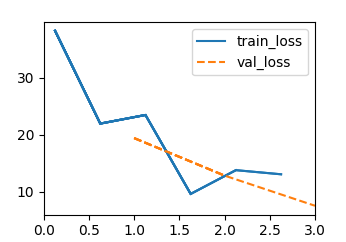


Amount of data: 400 \
lr: 0.03 \
Epochs: 3 \
error in estimating w: tensor([ 0.7499, -1.2214]) \
error in estimating b: tensor([1.3063]) \
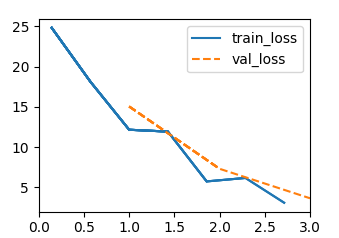


Amount of data: 1000 \
lr: 0.03 \
Epochs: 3 \
error in estimating w: tensor([ 0.0970, -0.1284]) \
error in estimating b: tensor([0.2203]) \
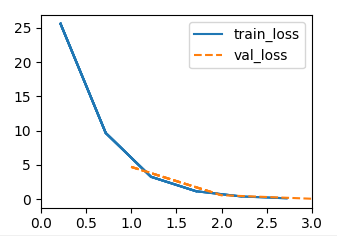


Amount of data: 2000 \
lr: 0.03 \
Epochs: 3 \
error in estimating w: tensor([ 0.0044, -0.0033]) \
error in estimating b: tensor([0.0093]) \
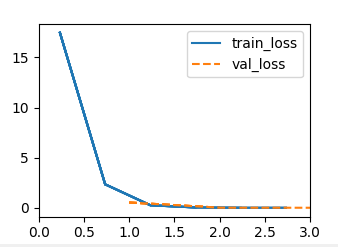 


Amount of data: 10000 \
lr: 0.03 \
Epochs: 3 \
error in estimating w: tensor([-2.7752e-04, -4.8637e-05]) \
error in estimating b: tensor([-0.0004]) \
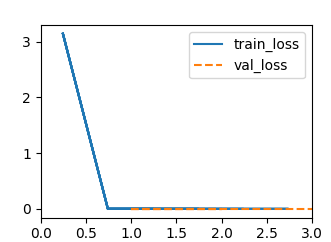

2.Why is the suggestion in the hint appropriate? \
Answer: Fast way to enconter the optmin size of dataset.